In [8]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None  # Will be shape [n_features, n_components]
        self.mean = None
        self.eigenvalues = None
        self.explained_variance_ratio_ = None

    def fit(self, X):
        # Convert to PyTorch tensor if not already
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32)

        # Center the data
        self.mean = torch.mean(X, dim=0)
        X_centered = X - self.mean

        # Compute covariance matrix
        N = X.shape[0]
        cov_matrix = torch.matmul(X_centered.T, X_centered) / (N - 1)

        # Compute eigenvalues and eigenvectors
        eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)

        # Sort eigenvalues and corresponding eigenvectors in descending order
        idx = torch.argsort(eigenvalues, descending=True)
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        # Store first n_components eigenvectors
        self.components = eigenvectors[:, :self.n_components]
        self.eigenvalues = eigenvalues[:self.n_components]

        return self

    def transform(self, X):
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32)
        X_centered = X - self.mean
        return torch.matmul(X_centered, self.components)

    def inverse_transform(self, X_transformed):
        return torch.matmul(X_transformed, self.components.T) + self.mean

In [10]:
def load_and_preprocess_data(train_path, test_path, selected_digits=[0, 1]):
    # Load data
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)

    # Separate labels and features
    X_train = train_data.drop('label', axis=1).values
    y_train = train_data['label'].values
    X_test = test_data.drop('label', axis=1).values
    y_test = test_data['label'].values

    # Filter selected digits
    train_mask = np.isin(y_train, selected_digits)
    test_mask = np.isin(y_test, selected_digits)

    X_train_filtered = X_train[train_mask]
    y_train_filtered = y_train[train_mask]
    X_test_filtered = X_test[test_mask]
    y_test_filtered = y_test[test_mask]

    # Convert to PyTorch tensors and normalize
    X_train_tensor = torch.tensor(X_train_filtered, dtype=torch.float32) / 255.0
    X_test_tensor = torch.tensor(X_test_filtered, dtype=torch.float32) / 255.0
    y_train_tensor = torch.tensor(y_train_filtered)
    y_test_tensor = torch.tensor(y_test_filtered)

    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

In [11]:
def calculate_mean_digit(X, y, digit):
    digit_mask = y == digit
    digit_data = X[digit_mask]
    return torch.mean(digit_data, dim=0)


def calculate_covariance_matrix(X):
    X_centered = X - torch.mean(X, dim=0)
    N = X.shape[0]
    return torch.matmul(X_centered.T, X_centered) / (N - 1)

In [12]:
def plot_digit(data, title):
    if torch.is_tensor(data):
        data = data.cpu().numpy()
    plt.figure(figsize=(4, 4))
    plt.imshow(data.reshape(28, 28), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [13]:
def plot_principal_components(pca_components, n_components=8):
    if torch.is_tensor(pca_components):
        pca_components = pca_components.cpu().numpy()

    # Transpose the components to get correct shape
    pca_components = pca_components.T

    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()

    for idx in range(n_components):
        axes[idx].imshow(pca_components[idx].reshape(28, 28), cmap='gray')
        axes[idx].axis('off')
        axes[idx].set_title(f'PC {idx + 1}')

    plt.tight_layout()
    plt.show()

In [14]:
def reconstruct_and_plot(X, dimensions, digit_idx=0):
    if not torch.is_tensor(X):
        X = torch.tensor(X, dtype=torch.float32)

    fig, axes = plt.subplots(1, len(dimensions), figsize=(20, 4))
    original = X[digit_idx]

    for idx, dim in enumerate(dimensions):
        pca = PCA(n_components=dim)
        pca.fit(X)
        X_transformed = pca.transform(X)
        X_reconstructed = pca.inverse_transform(X_transformed)
        reconstructed_digit = X_reconstructed[digit_idx].cpu().numpy()

        axes[idx].imshow(reconstructed_digit.reshape(28, 28), cmap='gray')
        axes[idx].axis('off')
        axes[idx].set_title(f'L={dim}')

    plt.suptitle('Digit Reconstructions with Different Numbers of Components')
    plt.show()

In [15]:
def plot_error_histogram(X, dimensions):
    if not torch.is_tensor(X):
        X = torch.tensor(X, dtype=torch.float32)

    plt.figure(figsize=(12, 6))

    for dim in dimensions:
        pca = PCA(n_components=dim)
        pca.fit(X)
        X_transformed = pca.transform(X)
        X_reconstructed = pca.inverse_transform(X_transformed)

        reconstruction_errors = torch.mean((X - X_reconstructed) ** 2, dim=1)
        plt.hist(reconstruction_errors.cpu().numpy(), bins=50, alpha=0.5, label=f'L={dim}')

    plt.xlabel('Mean Squared Error')
    plt.ylabel('Frequency')
    plt.title('Reconstruction Error Histogram')
    plt.legend()
    plt.show()

Using device: cpu

Analyzing digit 0


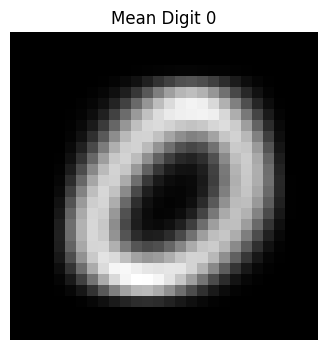

Covariance matrix shape: torch.Size([784, 784])
Components shape: torch.Size([784, 8])


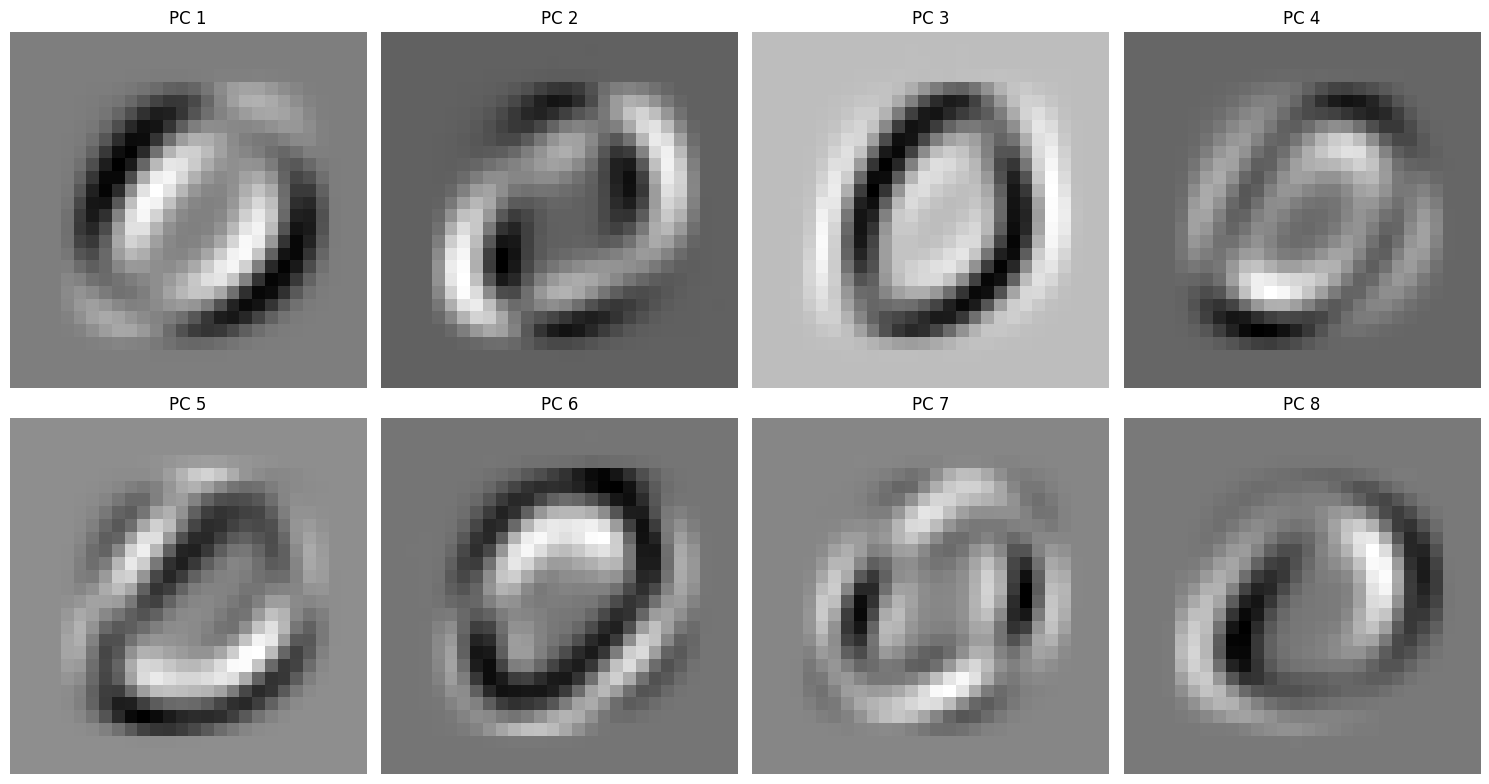

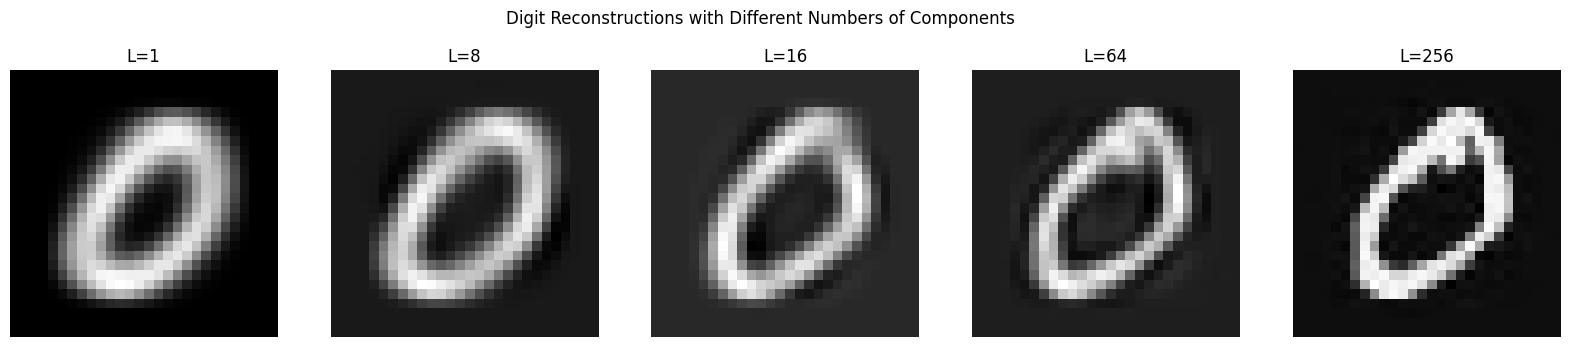

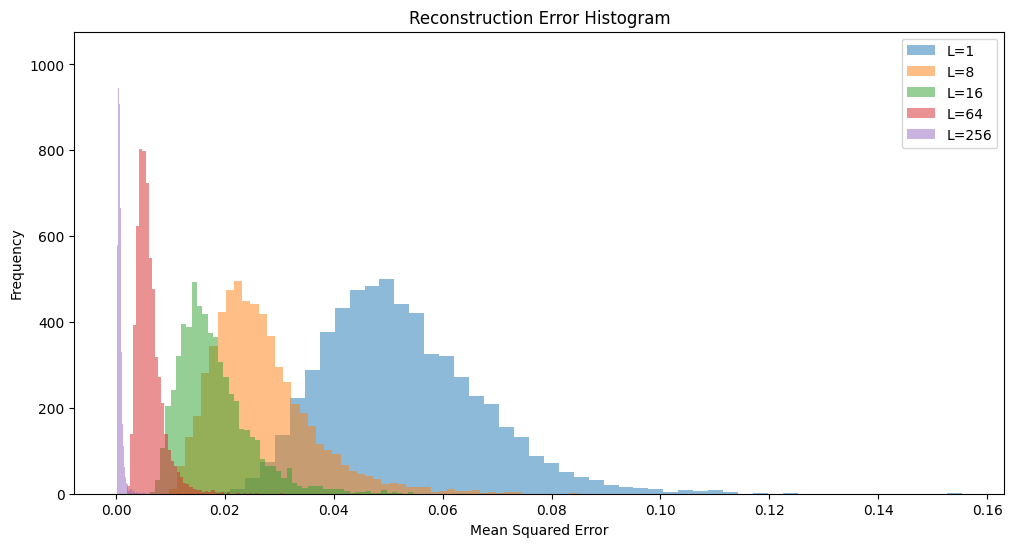


Analyzing digit 1


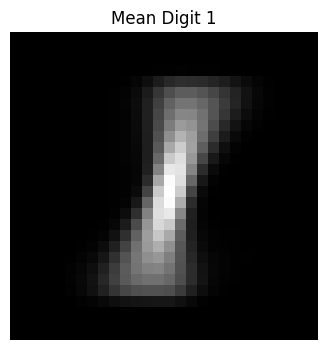

Covariance matrix shape: torch.Size([784, 784])
Components shape: torch.Size([784, 8])


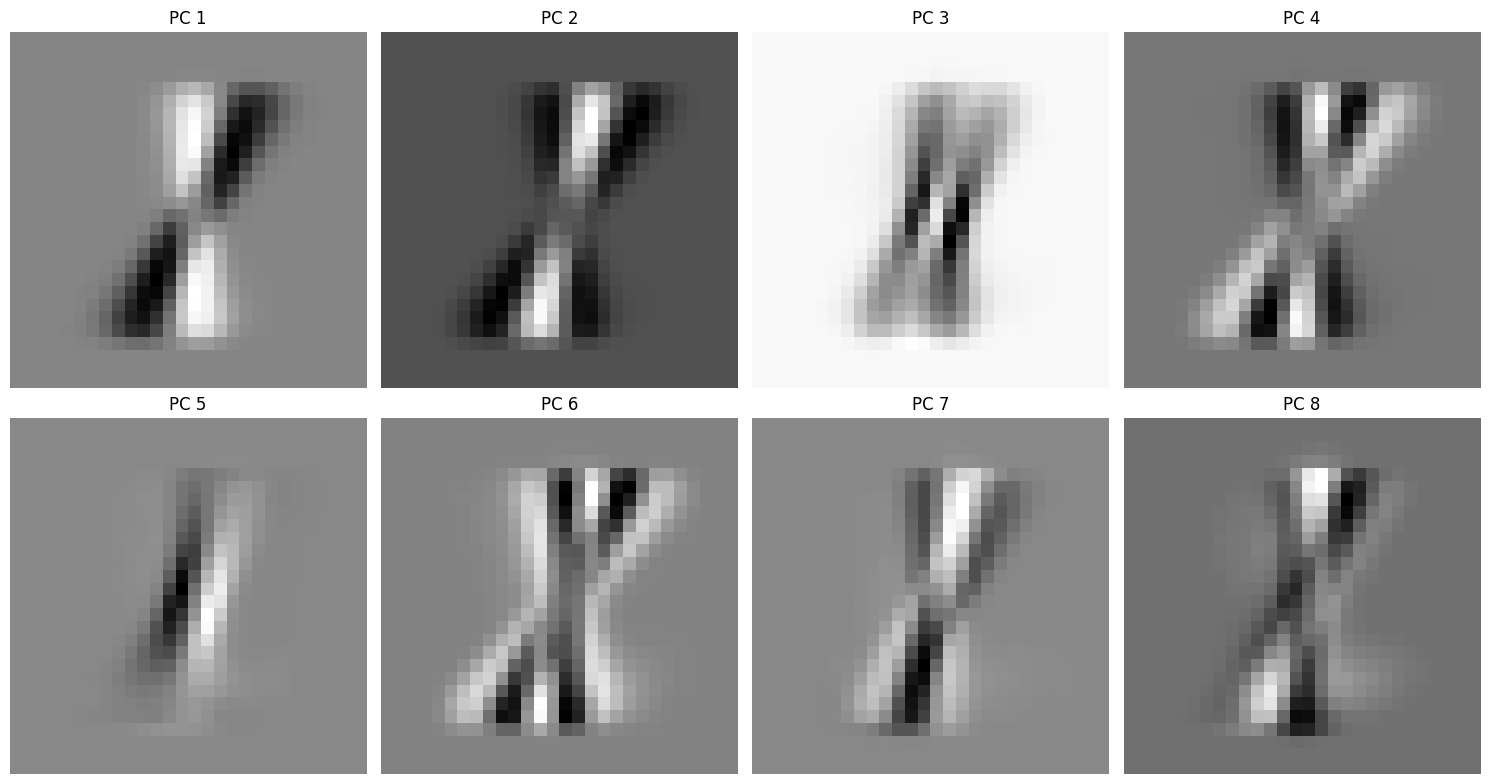

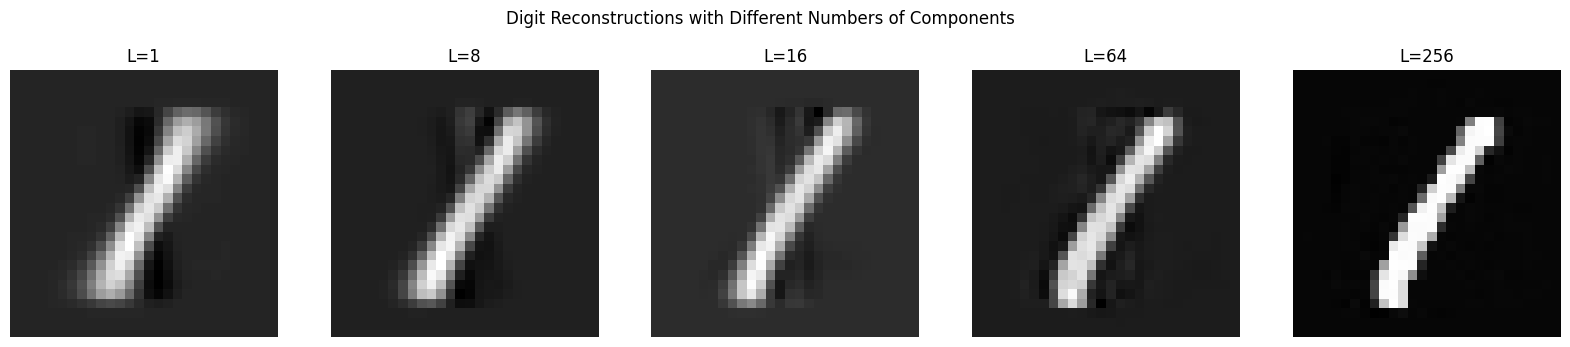

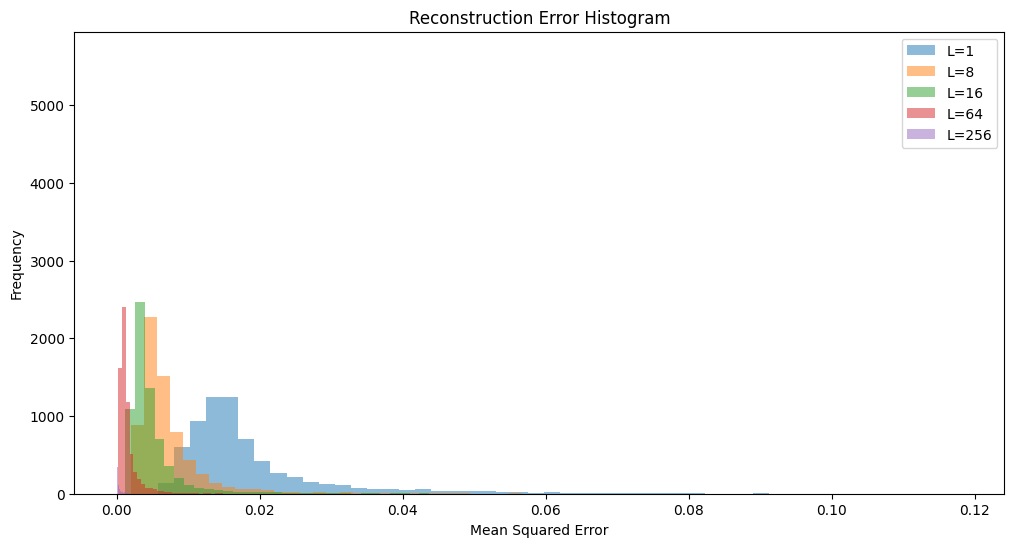

In [16]:
def main():
    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Selected digits for analysis
    selected_digits = [0, 1]  # You can modify these digits

    # Load and preprocess data
    X_train, y_train, X_test, y_test = load_and_preprocess_data('mnist_train.csv',
                                                                'mnist_test.csv',
                                                                selected_digits)

    # Move data to device
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    # For each selected digit
    for digit in selected_digits:
        print(f"\nAnalyzing digit {digit}")

        # Calculate and plot mean digit
        mean_digit = calculate_mean_digit(X_train, y_train, digit)
        plot_digit(mean_digit, f'Mean Digit {digit}')

        # Calculate covariance matrix
        digit_data = X_train[y_train == digit]
        cov_matrix = calculate_covariance_matrix(digit_data)
        print(f"Covariance matrix shape: {cov_matrix.shape}")

        # Perform PCA and plot components
        pca = PCA(n_components=8)
        pca.fit(digit_data)
        print(f"Components shape: {pca.components.shape}")  # Should be (8, 784)
        plot_principal_components(pca.components)

        # Plot reconstructions
        dimensions = [1, 8, 16, 64, 256]
        reconstruct_and_plot(digit_data, dimensions)

        # Plot error histograms
        plot_error_histogram(digit_data, dimensions)


if __name__ == "__main__":
    main()